# 語料分析流程：歌詞語料庫為例

謝舒凱 連大成 洪漢唐 李智堯

台大語言所 LOPE 實驗室

# Corpus Analytics Workflow

- Data collection (**crawling**)
- Data preprocessing (**cleaning** and **tokenization**)
- Data tagging and parsing (**pos**, **dependency formalism**)
- Exploratory data analysis (hypothesis formation via **statistics** and **visualization**)
- Corpus **annotation**
- Analysis and Application
  - Corpus-based linguistic analysis
  - Natural Language Processong/Machine Learning/AI applications

 ## Required Packages Installation


In [0]:
# Download some dependencies
# !git clone https://github.com/ldkrsi/jieba-zh_TW.git jieba_tw
!pip install opencc-python-reimplemented
!pip install zhon
!pip install jieba
!pip install -U scikit-learn
!pip install nltk
!pip install jseg

    100% |████████████████████████████████| 491kB 13.7MB/s 
  Running setup.py bdist_wheel for opencc-python-reimplemented ... - \ done
  Stored in directory: /root/.cache/pip/wheels/04/a7/12/2da0450c5d1d0eded738a5cf3bf2743b728e94561d922660b1
Successfully built opencc-python-reimplemented
    100% |████████████████████████████████| 102kB 4.5MB/s 
  Running setup.py bdist_wheel for zhon ... - done
  Stored in directory: /root/.cache/pip/wheels/0e/93/5a/ad2f403c359ba996e33c21bf18611d921413df9740ede2fcf4
Successfully built zhon
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.1)
    100% |████████████████████████████████| 1.9MB 2.3MB/s 
    100% |████████████████████████████████| 1.0MB 20.7MB/s 
  Running setup.py bdist_wheel for jseg ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ee/a1/f2/5254906493c141ed52e24fb26f45b8c61ede34d70151cdb444
  Running setup.py bdist_wheel for nltk ... - \ | / - done
  Stored in

#  Corpus Data Ingestion 語料擷取 

In [0]:
from google.colab import files
import re
import json
from pathlib import Path
from jseg import Jieba
from opencc import OpenCC
from zhon import hanzi
import string
import nltk
import io
import csv
import requests
from bs4 import BeautifulSoup as bs
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Lyrics Data Collection

- 以爬取李宗盛的歌詞為例

In [0]:
SONG_REGEX = re.compile(r'\n\n(\D+)\n{2,4}', re.DOTALL | re.MULTILINE)

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'
}
sess = requests.Session()
sess.headers.update(HEADERS)


def get_song_rows(singer_link):
    """Provide a link to a singer's Mojim page. Returns a list of BeautifulSoup tags"""
    if not singer_link.endswith('-A2.htm'):
        singer_link = singer_link.replace('.htm', '-A2.htm')
    soup = bs(sess.get(singer_link).text)
    return soup.select('dd.hb2, dd.hb3')
  
  
def get_song_attrs(rows):
    """
      Provide a list of BeautifulSoup tags containing information such as a link to a song's lyrics, 
      title, and release time. Returns a list of dictionaries containing the aforementioned information.
    """
    song_attrs_list = []
    visited = set()  # keep track of songs
    BASE_URL = "http://mojim.com"
    for row in rows:
        link = BASE_URL+row.select('span.hc1 a')[0].attrs['href']
        title = row.select('span.hc1 a')[0].text
        time = row.select('span.hc4')[0].text
        if title in visited:
            print(f'{title} already exists.')
            continue
        song_attrs_list.append({'link': link, 'title': title, 'time': time})
        visited.add(title)
    print(f'{len(song_attrs_list)} unique songs found.')
    return song_attrs_list

def get_song_lyrics(song_dicts):
    """Provide a dictionary containing song information. Returns the song's lyrics."""
    total = len(song_dicts)
    errors = []
    for idx, song_dict in enumerate(song_dicts, 1):
        link = song_dict['link']
        r = sess.get(link).text
        soup = bs(r, 'html5lib')
        try:
          soup = str(soup.select('dl.fsZx1')[0])
        except IndexError:
          continue
        else:
          # remove link
          soup = soup.replace(
              r'<br/>更多更詳盡歌詞 在 <a href="http://mojim.com">※ Mojim.com　魔鏡歌詞網</a><br/>', '')
          soup = soup.replace('<br/>', '\n')
          matches = SONG_REGEX.search(soup.strip())
          try:
            match = matches[1].strip()
            match = SONG_REGEX.search(match)[1]
            match = re.sub(r'\n更多更詳盡歌詞 在 ※ Mojim.com\u3000魔鏡歌詞網 ', '', match)
          except TypeError as e:
            print(e)
            print(song_dict)
            errors.append({'error': e, 'song': song_dict})
            continue
          else:
            song_dict['lyrics'] = match
          if idx % 25 == 0:
              print(f'{idx} of {total} complete')
    print('Done!')


def save(song_dict_list, filename):
    with open(filename, 'w') as fp:
        json.dump(song_dict_list, fp, ensure_ascii=False)
  


In [0]:
rows = get_song_rows('http://mojim.com/twh100041-A2.htm')  # Mojim singer's page
song_attrs = get_song_attrs(rows)
get_song_lyrics(song_attrs)
save(song_attrs, 'lyrics.json')

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): mojim.com
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twh100041-A2.htm HTTP/1.1" 200 7148
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x3x9.htm HTTP/1.1" 200 5205


飛 already exists.
問 already exists.
希望 already exists.
希望 already exists.
遠行 already exists.
領悟 already exists.
凡人歌 already exists.
凡人歌 already exists.
忙與盲 already exists.
因為寂寞 already exists.
因為寂寞 already exists.
鬼迷心竅 already exists.
寂寞難耐 already exists.
寂寞難耐 already exists.
傷心地鐵 already exists.
愛情少尉 already exists.
愛的代價 already exists.
夢醒時分 already exists.
你像個孩子 already exists.
你像個孩子 already exists.
我有話要說 already exists.
風櫃來的人 already exists.
生命中的精靈 already exists.
生命中的精靈 already exists.
如果你要離去 already exists.
我是真的愛你 already exists.
我是真的愛你 already exists.
當愛已成往事 already exists.
和自己賽跑的人 already exists.
給所有單身女子 already exists.
飛 already exists.
飛 already exists.
飛 already exists.
問 already exists.
山丘 already exists.
希望 already exists.
希望 already exists.
希望 already exists.
陰天 already exists.
遠行 already exists.
遠行 already exists.
領悟 already exists.
領悟 already exists.
一個人 already exists.
一個人 already exists.
七點鐘 already exists.
十二樓 already exists.
凡人歌 already exists.
凡人歌 already exists.
凡人

DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x4.htm HTTP/1.1" 200 5369
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x24.htm HTTP/1.1" 200 6180
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x22.htm HTTP/1.1" 200 6555


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x16x24.htm', 'title': '問', 'time': '2016-11'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x6x10.htm HTTP/1.1" 200 4963
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x11x4.htm HTTP/1.1" 200 6109
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x14.htm HTTP/1.1" 200 5833
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x1x3.htm HTTP/1.1" 200 5354
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x7.htm HTTP/1.1" 200 5975
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x12.htm HTTP/1.1" 200 5835
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x23.htm HTTP/1.1" 200 6915
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x11x2.htm HTTP/1.1" 200 4668
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x26.htm HTTP/1.1" 200 5712
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x16.htm HTTP/1.1" 200 5963
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12

'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x10x16.htm', 'title': '遠行', 'time': '2004-08'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x1.htm HTTP/1.1" 200 5226
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x29.htm HTTP/1.1" 200 5775
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x6.htm HTTP/1.1" 200 5883
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x26.htm HTTP/1.1" 200 5609
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x8x8.htm HTTP/1.1" 200 5429
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x16.htm HTTP/1.1" 200 5599
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x33.htm HTTP/1.1" 200 6325
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x6x8.htm HTTP/1.1" 200 4634
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x28.htm HTTP/1.1" 200 5873
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x6x9.htm HTTP/1.1" 200 5621
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x2

25 of 102 complete


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x8x5.htm HTTP/1.1" 200 5968
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x1x4.htm HTTP/1.1" 200 5669
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x30.htm HTTP/1.1" 200 6512
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x1.htm HTTP/1.1" 200 5122
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x6.htm HTTP/1.1" 200 6206
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x13.htm HTTP/1.1" 200 5852
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x9.htm HTTP/1.1" 200 5644
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x11x3.htm HTTP/1.1" 200 5178
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x12.htm HTTP/1.1" 200 5537
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x2.htm HTTP/1.1" 200 4875
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x14.

'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x9x2.htm', 'title': '不捨的牽絆', 'time': '1994-06'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x3.htm HTTP/1.1" 200 5742
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x32.htm HTTP/1.1" 200 5681
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x6.htm HTTP/1.1" 200 5916
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x5.htm HTTP/1.1" 200 5506
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x17.htm HTTP/1.1" 200 5803


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x10x5.htm', 'title': '沒有人知道', 'time': '2004-08'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x11x5.htm HTTP/1.1" 200 5309
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x11x1.htm HTTP/1.1" 200 5048
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x3x4.htm HTTP/1.1" 200 5016
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x5x2.htm HTTP/1.1" 200 6034


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x3x4.htm', 'title': '風櫃來的人', 'time': '1986-01'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x29.htm HTTP/1.1" 200 6141
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x31.htm HTTP/1.1" 200 5877
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x1.htm HTTP/1.1" 200 5219
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x4.htm HTTP/1.1" 200 5116
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x10.htm HTTP/1.1" 200 5997
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x25.htm HTTP/1.1" 200 6034
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x22.htm HTTP/1.1" 200 7055


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x16x25.htm', 'title': '寂寞的戀人啊', 'time': '2016-11'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x8.htm HTTP/1.1" 200 5066
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x4.htm HTTP/1.1" 200 5901
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x10.htm HTTP/1.1" 200 4933
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x6.htm HTTP/1.1" 200 5525


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x7x10.htm', 'title': '那一夜你喝了酒', 'time': '1989-01'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x7.htm HTTP/1.1" 200 5365
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x3.htm HTTP/1.1" 200 5406
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x8.htm HTTP/1.1" 200 5360
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x20.htm HTTP/1.1" 200 5706
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x8x12.htm HTTP/1.1" 200 5285
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x5.htm HTTP/1.1" 200 5426
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x2.htm HTTP/1.1" 200 5393
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x24.htm HTTP/1.1" 200 5932
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x25.htm HTTP/1.1" 200 6932
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x13.htm HTTP/1.1" 200 4926
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x15x1.

'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x16x13.htm', 'title': '讓我歡喜讓我憂(OT :OTOKOTO ONNA)', 'time': '2016-11'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x6x2.htm HTTP/1.1" 200 5034
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x10.htm HTTP/1.1" 200 5718
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x3.htm HTTP/1.1" 200 5376


75 of 102 complete


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x8x11.htm HTTP/1.1" 200 5633
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x2.htm HTTP/1.1" 200 5647
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x3x11.htm HTTP/1.1" 200 5308
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x22.htm HTTP/1.1" 200 5597
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x27.htm HTTP/1.1" 200 6702
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x21.htm HTTP/1.1" 200 6064


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x16x27.htm', 'title': '你們', 'time': '2016-11'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x34.htm HTTP/1.1" 200 6142
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x10x24.htm HTTP/1.1" 200 6203


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x10x34.htm', 'title': '寂寞', 'time': '2004-08'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x4x1.htm HTTP/1.1" 200 5412
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x4x7.htm HTTP/1.1" 200 5161
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x16.htm HTTP/1.1" 200 6462
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x9.htm HTTP/1.1" 200 5153


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x2x16.htm', 'title': '大地之歌', 'time': '1999-11'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x13x15.htm HTTP/1.1" 200 5539
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x3x13.htm HTTP/1.1" 200 5509
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x13.htm HTTP/1.1" 200 5855
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x9x10.htm HTTP/1.1" 200 5353
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x25.htm HTTP/1.1" 200 5508


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x9x10.htm', 'title': '由衷的感謝', 'time': '1994-06'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x13.htm HTTP/1.1" 200 5686
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x2x27.htm HTTP/1.1" 200 5676


'NoneType' object is not subscriptable
{'link': 'http://mojim.com/twy100041x2x13.htm', 'title': '始終只愛你', 'time': '1999-11'}


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x17x1.htm HTTP/1.1" 200 6657
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x8.htm HTTP/1.1" 200 6381
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x12x15.htm HTTP/1.1" 200 5598
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x3x12.htm HTTP/1.1" 200 5459
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x4x6.htm HTTP/1.1" 200 5157
DEBUG:urllib3.connectionpool:Resetting dropped connection: mojim.com
DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x7x6.htm HTTP/1.1" 200 5474


100 of 102 complete


DEBUG:urllib3.connectionpool:http://mojim.com:80 "GET /twy100041x16x12.htm HTTP/1.1" 200 6742


Done!


## Lyrics data preprocessing

In [0]:
user_dict = requests.get('https://raw.githubusercontent.com/lopentu/BestPracticeInCorpusProgramming/master/%E8%AA%9E%E6%96%99%E5%BA%AB%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86/dict.txt.big')
user_dict = io.StringIO(user_dict.text)
j = Jieba()
j.add_guaranteed_wordlist(user_dict)
  
STOPWORDS = requests.get('https://raw.githubusercontent.com/lopentu/BestPracticeInCorpusProgramming/master/%E8%AA%9E%E6%96%99%E5%BA%AB%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86/stopwords.txt')
STOPWORDS = STOPWORDS.text.splitlines()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /lopentu/BestPracticeInCorpusProgramming/master/%E8%AA%9E%E6%96%99%E5%BA%AB%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86/dict.txt.big HTTP/1.1" 200 3033919
DEBUG:jseg.jieba:loading default dictionary
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): raw.githubusercontent.com
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /lopentu/BestPracticeInCorpusProgramming/master/%E8%AA%9E%E6%96%99%E5%BA%AB%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86/stopwords.txt HTTP/1.1" 200 4200


In [0]:
def preprocess(song_dict_list, pos_tagging=True, remove_stopwords=True):
  print("Starting...")

  completed = []
  
  regex = re.compile(rf"[{hanzi.punctuation}{string.punctuation}]")
  for song in song_dict_list:
    try:
      title = song['title']
      lyrics = song['lyrics']
    except KeyError:
      continue
    # remove punctuation
    no_punc = regex.sub("", lyrics)
    # remove newlines
    no_newlines = no_punc.replace('\n', '')
    # remove other whitespace
    no_whitespace = no_newlines.replace(' ', '')

    if pos_tagging:
      seg = j.seg(no_whitespace, pos=True)
      if remove_stopwords:
        no_stopwords = [(word, tag) for word, tag in seg if word not in STOPWORDS]
        completed.append({
            'time': song['time'],
            'title': title,
            'lyrics': no_stopwords
        })
      else:
        completed.append({
            'time': song['time'],
            'title': title,
            'lyrics': seg
        })

    else:
      # returns a list instead of a generator
      seg = j.seg(no_whitespace)
      if remove_stopwords:
        no_stopwords = [(word, tag) for word, tag in seg if word not in STOPWORDS]
        completed.append({
            'time': song['time'],
            'title': title,
            'lyrics': no_stopwords
        })
      else:
        completed.append({
            'time': song['time'],
            'title': title,
            'lyrics': seg
        })
  print('Completed!')
    
  return completed

def save(song_dict_list, filename):
  # save as JSON
  with open(f'{filename}.json', 'w') as fp:
    json.dump(song_dict_list, fp, ensure_ascii=False)
  # save as CSV
  with open(f'{filename}.csv', 'w') as fp:
    dict_writer = csv.DictWriter(fp, ['title', 'time', 'lyrics'])
    dict_writer.writeheader()
    for d in song_dict_list:
      dict_writer.writerow({
          'title': d['title'],
          'time': d['time'],
          'lyrics': " ".join(f'{token}/{tag}' for token, tag in (d['lyrics']))
      })
  # save as vertical plain text
  with open(f'{filename}.vrt', 'w') as fp:
    for d in song_dict_list:
      lyrics = d['lyrics']
      print('<s>', file=fp)
      for token, tag in lyrics:
        print(f'{token}\t{tag}', file=fp)
      print('</s>', file=fp)
      
  # save as plain text
  with open(f'{filename}.txt', 'w') as fp:
    for d in song_dict_list:
      lyrics = d['lyrics']
      lyrics = " ".join((token for token, pos in lyrics))
      print(lyrics, file=fp)

In [0]:
processed = preprocess(song_attrs)

Starting...
Completed!


In [0]:
save(processed, 'lizongsheng')
!ls

lizongsheng.csv   lizongsheng.txt  lyrics.json
lizongsheng.json  lizongsheng.vrt  sample_data


In [0]:
files.download('lizongsheng.txt')

## **NLP-enhanced data processing**

Stanford (Chinese) NLP

- POS tagging
- Dependency parsing
- Named Entities Recognition (NER)
- (Sentiment analysis)

# Exploratory Corpus Data Analysis 語料探索分析

Corpus Statistics and Visualization

- Descriptive Statistics
- Statistical Testing
- Association and Productivity Measure
- Multivaraite Statistics (Clustering)


[(('愛情', 'Nad'), 13), (('溫柔', 'NN'), 6)]


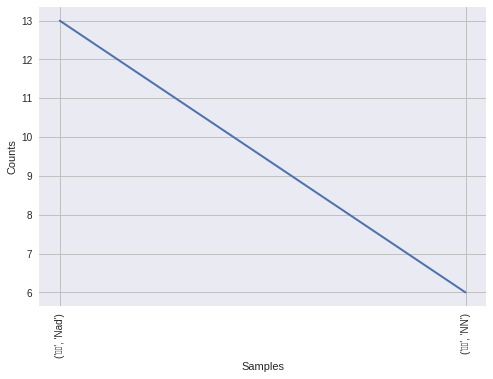

[(('溫柔', 'NN'), 6), (('愛情', 'Nad'), 2)]


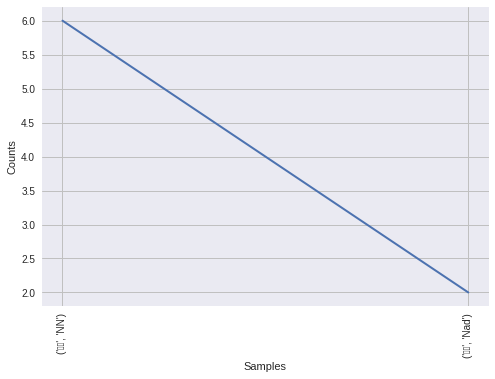

[(('愛情', 'Nad'), 24), (('溫柔', 'NN'), 8)]


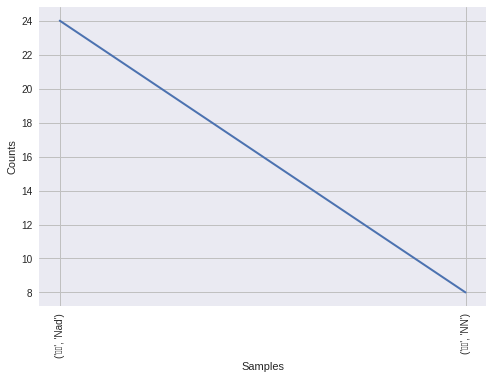

In [0]:
def plot_era(start='2000',end='2010'):
  words=[]
  for d in processed:
    if d['time']>start and d['time']<end:
      words+=d['lyrics']
  fdist=nltk.FreqDist([w for w in words if w[0] in ['愛情','溫柔','我']])
  print(fdist.most_common(5))
  fdist.plot()

plot_era(start='1980',end='1990')
plot_era(start='1990',end='2000')
plot_era(start='2000',end='2010')

> Use `panda` library to conduct **data manipulation**  (preparation, transformation, aggregation)

> *Note*: exploratory *structured* vs *unstructured*  data analysis

### Corpus Data Summary, Query and Graphics

- Corpus Basic statistics
-  *Plot, Barplot, and Histograms* (check `Code snippets: Altair`) https://altair-viz.github.io/
-  Visualization 


### Basic Corpus Statistics and Plot

### More text-oriented plot
- *Dispersion* and *Strip charts*


In [0]:
#code
## for unstructured data

### Concordance

In [0]:
import nltk
import jieba
raw = open(....).read()
corpus = nltk.Text(jieba.lcut(raw))
corpus.concordance(u'愛', width = 40, lines = 15)

SyntaxError: ignored

### Visualization

- *Word cloud*
- *ScatterText*

#### Word Cloud

#### Scatter Text

- a recent method to make legible, interactive scatter plots for text visualization [Jason S. Kessler ](https://github.com/JasonKessler)
- Check the author's [Tutorial video](https://www.youtube.com/watch?v=H7X9CA2pWKo)

In [0]:
!pip install --upgrade scattertext
import sys
import pandas as pd
import scattertext as st
import numpy as np
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [0]:
from __future__ import print_function
from scattertext import CorpusFromParsedDocuments
from scattertext import chinese_nlp
from scattertext import produce_scattertext_explorer

In [0]:
## compare chinese translations of tale of two cities and ulysses, from http://www.pku.edu.cn/study/novel/ulysses/cindex.htm

df = pd.read_csv('https://cdn.rawgit.com/JasonKessler/scattertext/e508bf32/scattertext/data/chinese.csv')
df['text'] = df['text'].apply(chinese_nlp)
corpus = CorpusFromParsedDocuments(df,
                                   category_col='novel',
                                   parsed_col='text').build()
html = produce_scattertext_explorer(corpus,
                                    category='Tale of Two Cities',
	                                  category_name='Tale of Two Cities',
	                                  not_category_name='Ulysses',
	                                  width_in_pixels=1000,
	                                  metadata=df['novel'],
	                                  asian_mode=True)
# open('./demo_chinese.html', 'w').write(html)
# print('Open ./demo_chinese.html in Chrome or Firefox.')



In [0]:
display(HTML(html))

### Clustering

> Clustering is the task of organizing unlabelled objects in a way that objects in the same group are similar to each other and dissimilar to those in other groups. In other words, clustering is like *unsupervised classification* where the algorithm models the *similarities* instead of the boundaries.

#### Basic notions

- a **distance measure** to define whether or not two documents are similar.

- a **criterion function** to compute the quality of our clusters, and 

- an algorithm to **optimize** this criterion.

#### Principal Component Analysis (PCA)

#### t-SNE ( t-distributed stochastic neighbor embedding)

- pretty useful when it comes to visualizing similarity between objects. It works by taking a group of high-dimensional (100 dimensions via Word2Vec) vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. 

- The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words.

- resolution of syntactic and semantic ambiguity (polysemy)

Steps

- Clean the data
- Build a corpus
- Train a Word2Vec Model
- Visualize t-SNE representations of the most common words

In [0]:
# import pandas as pd
# pd.options.mode.chained_assignment = None 
# import numpy as np
# import re
# import nltk

# from gensim.models import word2vec

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# %matplotlib inline


In [0]:
!pip install gensim
import gensim
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [0]:
print(model['computer'])
model.similar_by_word('computer')

In [0]:
model.wv['trump']


## Co-occurrence, Association and Productivity Measures

- Co-occurrence is the simultaneous occurrence of *usually two* linguistic phenomena.

- Finding lexical-grammatical patterns is useful both for linguistic and lexicographical studies.


### Collocation 搭配現象

- statistically significant co-occurrence of linguistic forms.

> You shall know a word by the company it keeps (Firth, 1957).

- lexical and grammatical collocations




### Colligation
- like collocation except that it has a grammatical component.


### Collostruction

three methods proposed by (Stefanowitsch and Gries)

1. **Collexeme analysis** : measures the mutual attraction of lexemes and constructions.

  - (Fisher's exact test; odds ratio, $G^2$, MI, $\chi^2$)

2. Distinctive collexeme analysis
  
   - (Fisher's exact test, $G^2$) 

3. Co-varying collexeme analysis

  - (Fisher's exact test, odds ration, $G^2$)

## Association Measures

- measure the significant co-occurrences (between two units) on the basis of *contingency table*:  (¬ means “other than”)



Age           | W2  | ¬ W2 | row totals
--------------|:-----:|-----:| ----:|------------------------
W1    | a |  b |    a+b 
 ¬ W1  | c |  d |  c+d
column totals  | a+c | b+d |  a+b+c+d 


Cell a denotes the number of times W1 and W2 co-occur, cell b the number of times W1 co-occurs with words other than W2, cell c the number of times W2 co-occurs with words other than W1, and cell d the number of times that words other than W1 and W2 co-occur.





### Four popular association measures

-  Mutual information
- Fisher's exact test
- The $\chi^2$ test 
- The log-likelihood ration test

##### Mutual Information

Church and Hanks (1990, p. 23) define $I(W1,W2)$, the mutual information $\mathcal{I}$ of two words W1 and W2, as
follows:

$
I (W_{1}, W_{2}) = log_{2}\frac{P(W_{1}, W_{2})}{P(W_{1})P(W_{2})}$




### Lexical Richness and Productivity

- Types, Tokens, and TTR (type-token ratio)
- Vocabulary Graowth Curve








# Corpus Annotation and Analysis 語料標記分析

- Data is often annotated using both automatic taggers/parsers and a growing set of manual annotation tools (e.g. EXMARaLDA, ELAN, annotate/Synpathy, MMAX, RSTTool, Arborator, WebAnno, Atomic), 
- E.g, ANNIS provides the means for visualizing and retrieving this data. Pepper is used to import the multiple annotation formats into ANNIS.

![ANNIS](http://corpus-tools.org/annis/images/annis3_full.png)

easier version: ![WebAnno](https://webanno.github.io/webanno/assets/img/logo.png)

![Annotation is a process](https://webanno.github.io/webanno/releases/3.4.6/docs/user-guide/images/progress_workflow.jpg)

## `WebAnno` annotation practice

> WebAnno (Eckart de Castilho, R. et al. 2016) is a general purpose web-based annotation tool for a wide range of linguistic annotations including various layers of morphological, syntactical, and semantic annotations. Additionaly, custom annotation layers can be defined, allowing WebAnno to be used also for non-linguistic annotation tasks.

### Sentiment and Emotion Annotation

- Sentiment Polarity annotation
- Emotion annotation `REMAN corpus (Relational EMotion ANnotation)`(Kim et al. 2018)



## Using WebAnno

- Register [WebAnno.LOPE](http://140.112.147.121:8080) or 
- Install [`Docker`](https://docs.docker.com/) and run the [Webanno](https://webanno.github.io/webanno/releases/3.4.7/docs/user-guide.html#_run_using_docker) locally

#Applications 應用

### Sentiment Analysis / Emotion detection

### Lyrics generation

-  Use LSTM (Long Short Term Memory) neural network, to avoid the long-term dependency problem. 

- [中文歌詞產生器示例](http://140.112.147.125:5000/)




## Exercise.1 標記與分析練習

- 利用 `webanno` 標記下載歌詞的情緒極度（正、負、中性）
- 比較之前基於情緒辭典預測器的正確率

# COPENS 開放語料庫計畫

- Goals

    - Corpus as Human-Machine collaboration interface人機協作、學習與互惠
    - Open data and source 

- Corpus Query Language 教學: COPENS:: LYRICS 歌詞語料庫為例
    - [Basics](https://www.sketchengine.eu/documentation/cql-basics/)  
    
    - [Compare](https://www.sketchengine.eu/documentation/corpus-querying/)



## Corpus  Query Language

- 先要了解 `lemma`, `word`, `pos`, 以及一點 `regular expression`

- [中研院詞類標記集](http://ckipsvr.iis.sinica.edu.tw/papers/category_list.pdf) , [簡化詞類](http://ckipsvr.iis.sinica.edu.tw/), 


![很貴的書](https://images.tandf.co.uk/common/jackets/agentjpg/978113894/9781138949447.jpg)


### Some examples

- `[word = "下雨"]`
- `[tag = "Di"]`
- Regular expressions can be used with CQL. e.g., 
`[word=".*念"]`


## Exercise.2 搜尋練習

- Upload your own lyrics corpus to `COPENS`
- Search terms with `CQL`

# Reference

- Evgeny Kim and Roman Klinger. Who Feels What and Why? Annotation of a Literature Corpus with Semantic Roles of Emotions. In Proceedings of COLING 2018, the 27th International Conference on Computational Linguistics, Santa Fe, USA, August 2018.